## Import Modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip

## Step 1: Compute the camera calibration using chessboard images

In [2]:
def calibrate_camera(images, nx=9, ny=6):
    """"
    images = paths to the images used to calibrate the camera
    nx = Number of inside corners in x
    ny = Number of inside corners in y
    """

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    print (images)
    for fname in images:    

        img = cv2.imread(fname)
#         print (img.shape)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)


['./camera_cal/calibration3.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration18.jpg']
Camera successfully calibrated.


## Step 2: Apply Distortion Correction to Chessboard Image

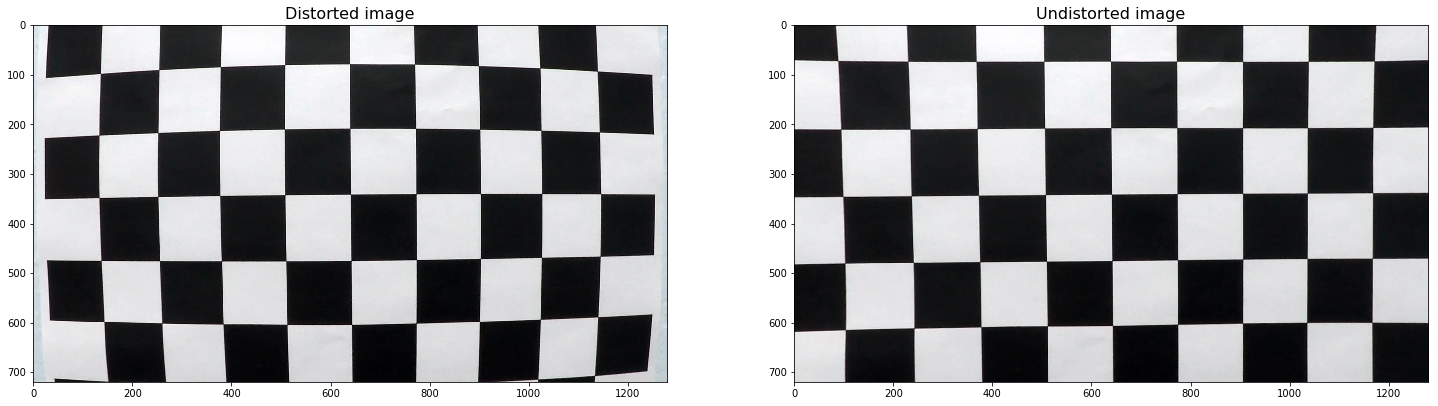

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, None)

def plot_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
    
plot_images(img, 'Distorted image', undistorted_img, 'Undistorted image')

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

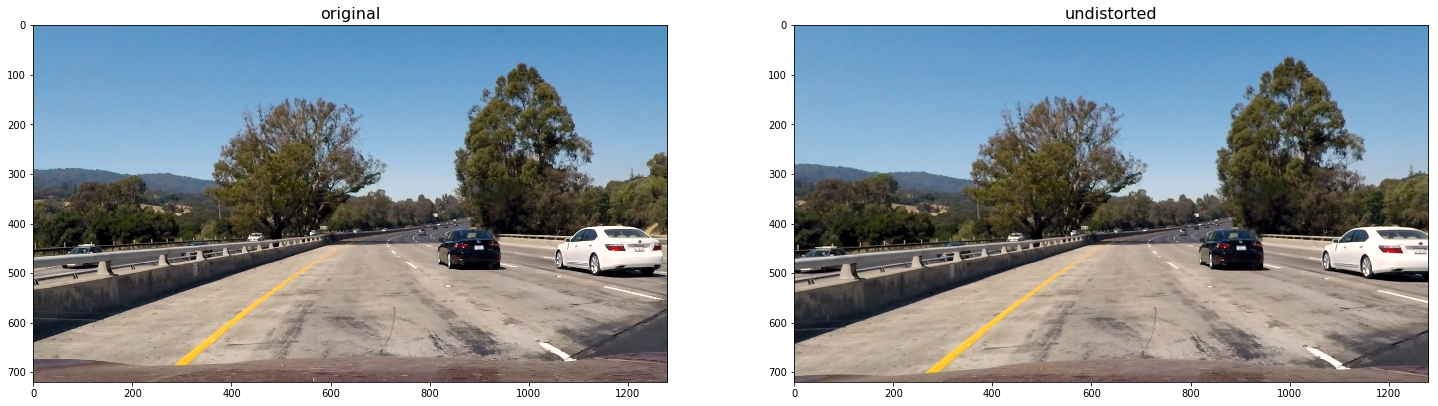

In [4]:
# Load image, convert to RGB, undistort it
original = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

plot_images(img, 'original', undistorted, 'undistorted')

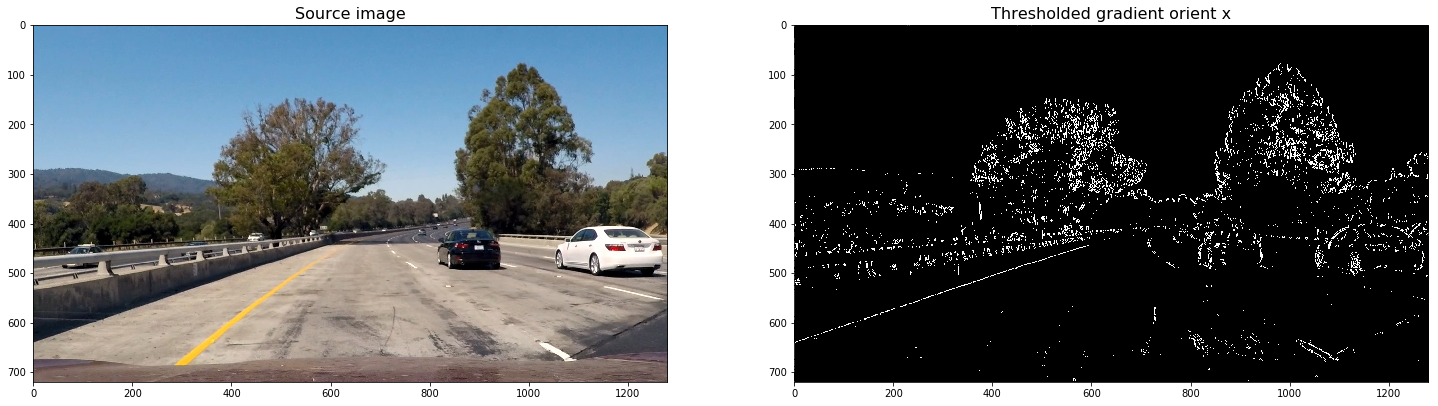

In [5]:
# Define a function that applies Sobel x or y, 

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


gradient_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

plot_images(img, 'Source image', gradient_x, 'Thresholded gradient orient x')

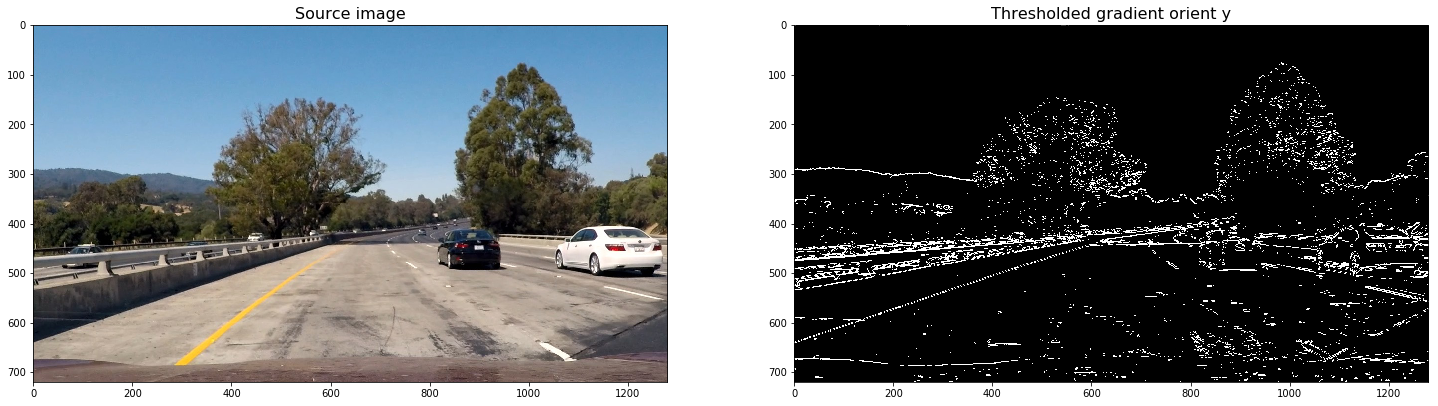

In [6]:
gradient_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))

plot_images(img, 'Source image', gradient_y, 'Thresholded gradient orient y')


## Calculate Gradient Magnitude

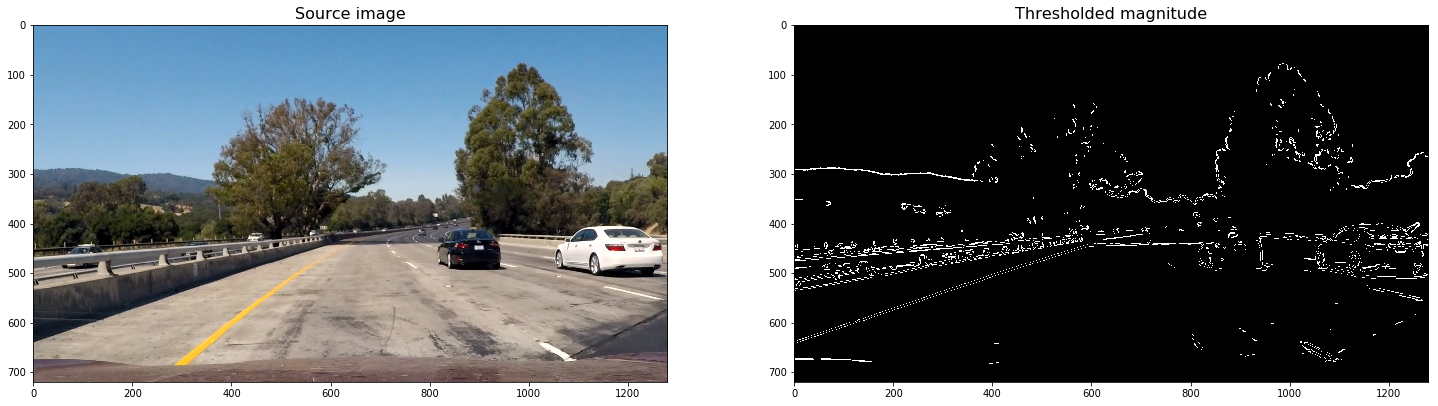

In [7]:
def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag)/255 
    
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

mag_binary = magnitude_threshold(img, sobel_kernel=15, thresh=(70, 100))

# Plot the result
plot_images(img, 'Source image', mag_binary, 'Thresholded magnitude')

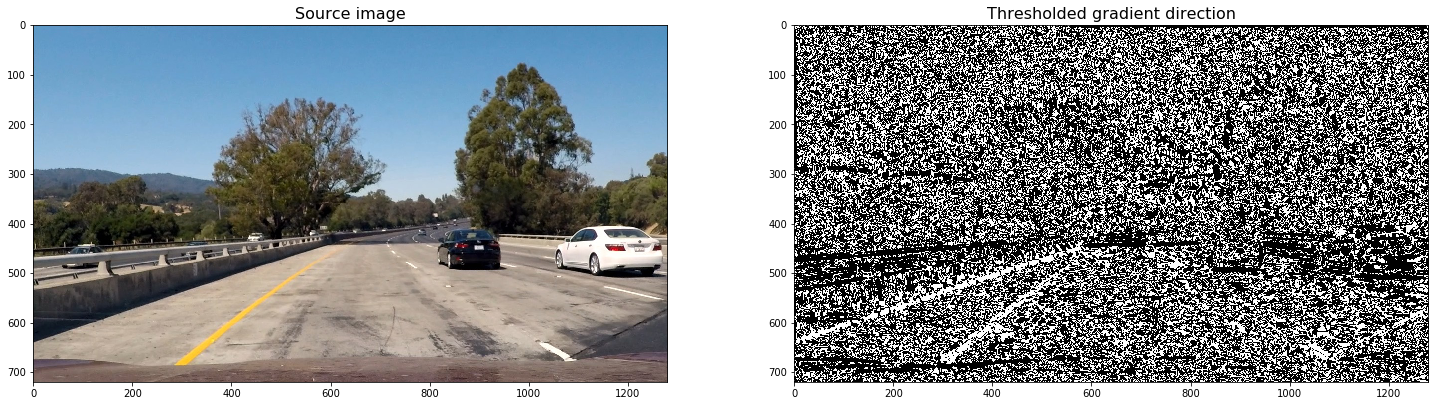

In [8]:
def direction_threshold(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
plot_images(img, 'Source image', dir_binary, 'Thresholded gradient direction')

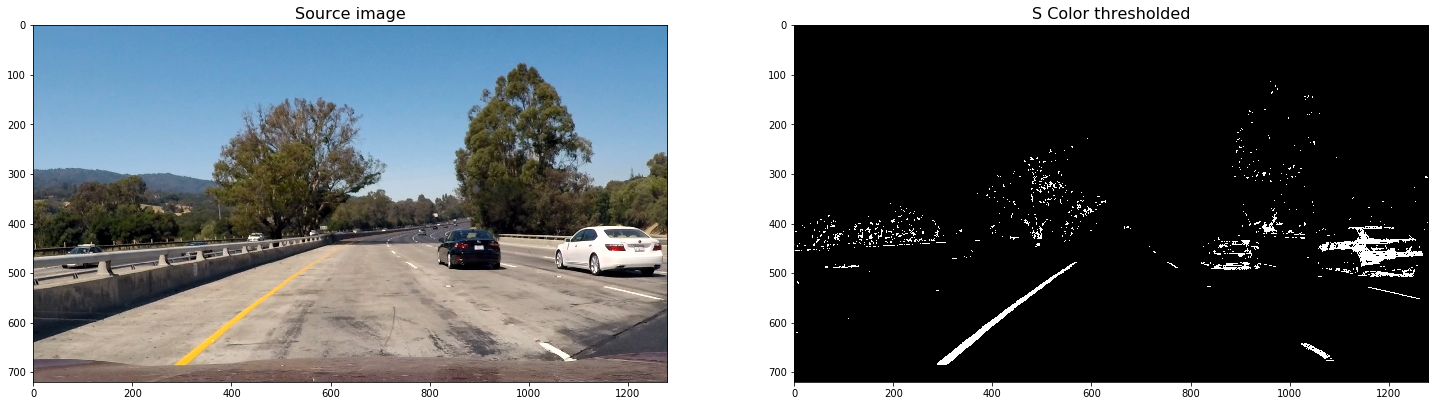

In [9]:
def col_thresh(img, thresh=(170, 255)):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel
    s_channel = hls[:,:,2] 
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    # Return the binary image
    return binary_output

col_binary = col_thresh(img, thresh=(170, 255))

plot_images(img, 'Source image', col_binary, 'S Color thresholded')

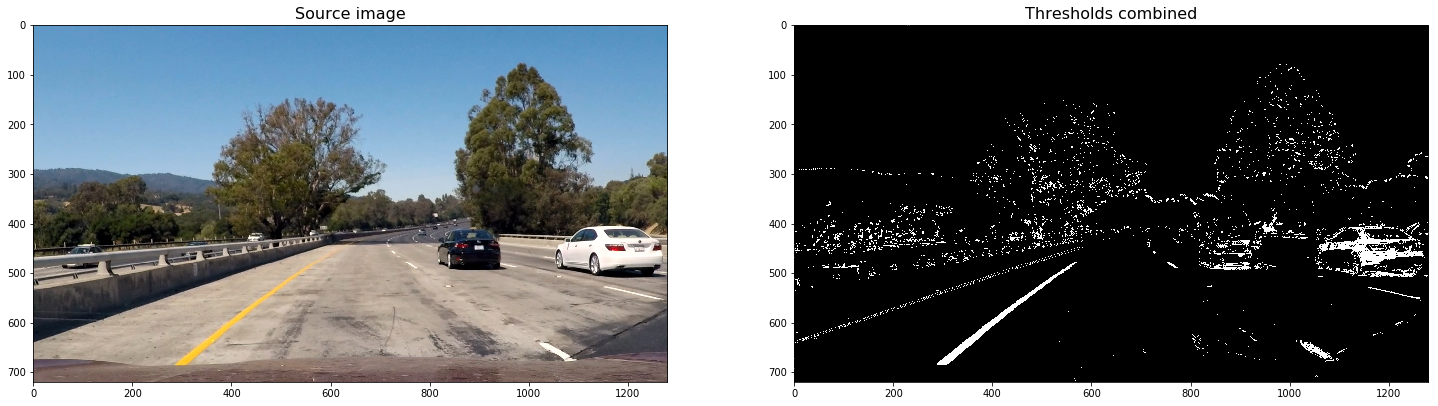

In [10]:
def combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15):
    combined = np.zeros_like(dir_binary)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1

    return combined

combined = combine_threshs(gradient_x, gradient_y, mag_binary, dir_binary, col_binary, ksize=15)

plot_images(img, 'Source image', combined, 'Thresholds combined')

## Step 4: Apply a perspective transform

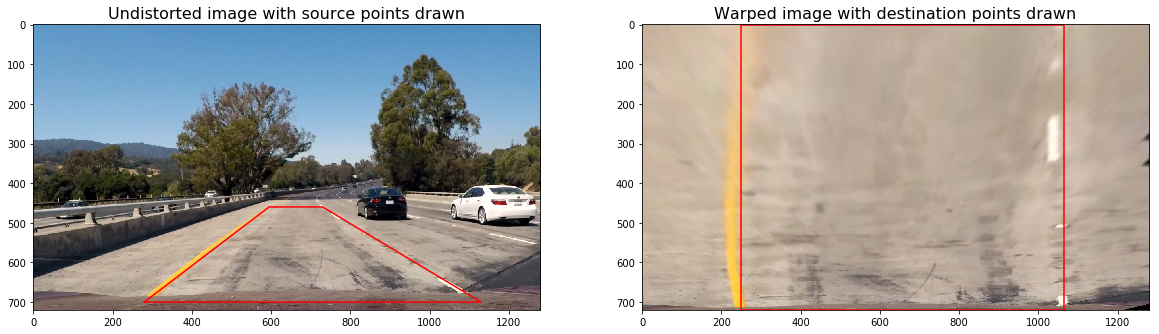

In [11]:
def warp(img, source_coordinates=None, dest_coordinates=None):
#     print (img)
    img_size = (img.shape[1], img.shape[0])
#     print (source_coordinates)
    
    if source_coordinates is None:
        source_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [730,  460],  # Top right
             [1130, 700]]) # Bottom right
    if dest_coordinates is None:
        dest_coordinates = np.float32(
            [[250,  720],  
             [250,    0],  
             [1065,   0], 
             [1065, 720]])
    Minverse = cv2.getPerspectiveTransform(dest_coordinates, source_coordinates)
    M = cv2.getPerspectiveTransform(source_coordinates, dest_coordinates)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minverse
    
source_coordinates = np.float32(
            [[280,  700],  
             [595,  460],  
             [730,  460],  
             [1130, 700]]) 

dest_coordinates = np.float32(
            [[250,  720],  
             [250,    0],  
             [1065,   0], 
             [1065, 720]])

warped_img, _ , Minv  = warp(img, source_coordinates, dest_coordinates)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(source_coordinates).get_xy()[:, 0], Polygon(source_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dest_coordinates).get_xy()[:, 0], Polygon(dest_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

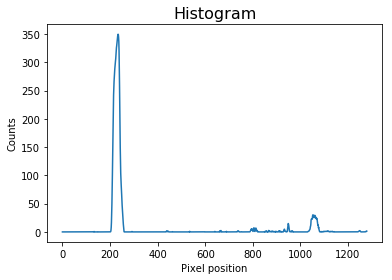

In [12]:
def hist(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)
    
combined_warped = warp(combined)[0]
histogram = hist(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)
# cv2.imwrite('first.jpg', combined_warped)
# print (combined_warped)
# plt.imshow(combined_warped,'gray')

In [13]:
def find_lane_pixels(combined_warped):
    
#     cv2.imwrite('first.jpg', combined_warped)
    # Take a histogram of the bottom half of the image
    histogram = hist(combined_warped)
#     plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((combined_warped, combined_warped, combined_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    #Set the width of the windows +/- margin
    margin = 100
    #Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(combined_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_warped.shape[0] - (window+1)*window_height
        win_y_high = combined_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#     cv2.imwrite('windows.jpg', out_img)
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(combined_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(combined_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_warped.shape[0]-1, combined_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
#     cv2.imwrite('colored.jpg', out_img)
    # Plots the left and right polynomials on the lane lines
    points = np.asarray([left_fitx,ploty]).astype(np.int32) 
#     print (points)
    for index in range(out_img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (0,255,255))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (0,255,255))
    cv2.imwrite('Fit_polynomial_and_sliding_windows.jpg', out_img)

    return [out_img,left_fit,right_fit]
out_img,left_fit, right_fit = fit_polynomial(combined_warped)
# print (left_fit, right_fit)

True

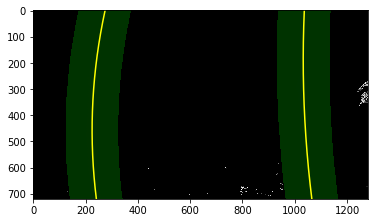

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(combined_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = combined_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(combined_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((combined_warped, combined_warped, combined_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,ploty, left_fitx, right_fitx

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,ploty, left_fitx, right_fitx = search_around_poly(combined_warped)

# View your output
plt.imshow(result)
# print (ploty)
cv2.imwrite('Margin_windows.jpg', result)

In [15]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [16]:
curvature_rads = curvature_radius(left_fitx, right_fitx, img_shape = img.shape)
print (curvature_rads)

(552.09391518163272, 1121.5135358490743)


In [17]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

offsetx = car_offset(left_fitx, right_fitx, img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.0612378436536 m.


In [18]:
def draw_lane(img, warped_img, left_fitx, right_fitx,ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

img_lane = draw_lane(img, combined_warped, left_fitx, right_fitx, ploty, Minv)
cv2.imwrite('Lane_detected.jpg', img_lane)

True

In [19]:
def overlay_info(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane curvature: {:.2f} m'.format(curvature_rads[0]), 
                (45, 45), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane curvature: {:.2f} m'.format(curvature_rads[1]), 
                (45, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal offset: {:.2f} m'.format(offsetx), 
                (45, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img
out_img = overlay_info(img_lane, left_fitx, right_fitx)
cv2.imwrite('Lane_detected_with_info.jpg', out_img)

True

In [27]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None
#         print (self.ret, self.mtx, self.dist, self.rvecs, self.tvecs)
    def __call__(img,self):

        img = cv2.undistort(img, mtx, dist, None, mtx)

    

In [29]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip = VideoFileClip(input_video)

process_image = ProcessImage('./camera_cal/calibration*.jpg')

output = clip.fl_image(process_image)

# self.ret, self.mtx, self.dist, self.rvecs, self.tvecs

['./camera_cal/calibration3.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration18.jpg']
Camera successfully calibrated.


TypeError: src is not a numpy array, neither a scalar